In [65]:
#%pip install -r requirements_new.txt

# LSTM forecast
Author: Oscar Janossy   
Date: 2025-05-19  
Description: System imbalance forecating with LSTM model

The implementation of the LSTM model is made following the examples of the book:  
**Modern Time Series Forecasting with Python**  
- **Repository:** [PacktPublishing/Modern-Time-Series-Forecasting-with-Python](https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python)  
- **Author:** Manu Joseph & Jeffrey Tackes
- **License:** MIT License  
- **Accessed on:** 2025-05-17 


# Import

In [ ]:
# Core Python & System
import os
import sys
from pathlib import Path
from itertools import cycle


# Data & Utilities
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt


# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

# Optuna for hyperparameter tuning
import optuna

# PyTorch & PyTorch Lightning
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback

# Progress Bar
from tqdm.autonotebook import tqdm


# Typing (Python 3.9+ syntax)
from typing import Tuple, Union, Optional

# Reproducibility
pl.seed_everything(42)
np.random.seed(42)
tqdm.pandas()

# Path Setup
directory = os.getcwd()
sys.path.insert(0, directory)

# Notebook Extensions
%load_ext autoreload
%autoreload 2


Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
data = pd.read_csv(directory + '/data/data.csv', parse_dates=['start_date'], index_col=0)
data.head()

,start_date,Imbalance,ISP (lag1),Day-ahead Spot Price,WIND_ONSHORE - D-1,WIND_ONSHORE - ID,WIND_ONSHORE - CURRENT,SOLAR - D-1,SOLAR - ID,SOLAR - CURRENT,...,day_holiday,Month_sin,Month_cos,Week_sin,Week_cos,Dayofweek_sin,Dayofweek_cos,1/2 Hour of the day_sin,1/2 Hour of the day_cos,1/2 Hour of the day
0,2017-12-31 23:00:00+00:00,-377.32,29.22,6.74,10081.0,9839.0,9839.0,0.0,0.0,0.0,...,0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.781831,0.62349,-1.305262e-01,0.991445,47
1,2017-12-31 23:30:00+00:00,-468.52,29.22,6.74,10047.5,9820.5,9820.5,0.0,0.0,0.0,...,0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.781831,0.62349,-2.449294e-16,1.000000,48
2,2018-01-01 00:00:00+00:00,-1467.79,18.11,4.74,10014.0,9802.0,9802.0,0.0,0.0,0.0,...,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,1.305262e-01,0.991445,1
3,2018-01-01 00:30:00+00:00,-1467.09,20.49,4.74,9805.0,9717.5,9717.5,0.0,0.0,0.0,...,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,2.588190e-01,0.965926,2
4,2018-01-01 01:00:00+00:00,-1230.20,23.22,3.66,9596.0,9633.0,9633.0,0.0,0.0,0.0,...,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,3.826834e-01,0.923880,3


In [43]:
target = 'Imbalance'

## Create the the custom function and classes

In [48]:
#Function to compute the metrics

def forecast_metrics(y_true, y_pred, seasonality: int = 1):
    """
    Compute MAE, MASE and RMSSE of a forecast against a naive (lagged) baseline.

    Parameters
    ----------
    y_true : array‑like, shape (n,)
        The true values.
    y_pred : array‑like, shape (n,)
        Your model’s predictions.
    seasonality : int, default=1
        The lag to use for the naive forecast (1 = last timestep).

    Returns
    -------
    mae : float
        Mean absolute error of your predictions.
    mase : float
        Mean absolute scaled error:
            mae_model / mae_naive
    rmsse : float
        Root mean squared scaled error:
            rmse_model / rmse_naive
    """
    # ensure 1‑D numpy arrays
    y_true = np.array(y_true).astype(float).reshape(-1)
    y_pred = np.array(y_pred).astype(float).reshape(-1)
    n = len(y_true)
    if len(y_pred) != n:
        raise ValueError("y_true and y_pred must have the same length")

    # 1) MAE of your model
    mae = np.mean(np.abs(y_true - y_pred))

    # 2) Build the naive forecast (lag = seasonality)
    #    y_naive[t] = y_true[t - seasonality]
    #    first `seasonality` points are undefined → we drop them
    y_naive = np.roll(y_true, seasonality)
    mask = np.arange(n) >= seasonality
    y_true_cut, y_naive_cut, y_pred_cut = (
        y_true[mask],
        y_naive[mask],
        y_pred[mask],
    )

    # 3) Errors of the naive baseline
    err_naive = y_true_cut - y_naive_cut

    # 4) MASE = MAE_model / MAE_naive
    mae_naive = np.mean(np.abs(err_naive))
    mase = mae / mae_naive

    # 5) RMSE of your model and of the naive baseline
    rmse = np.sqrt(np.mean((y_true_cut - y_pred_cut) ** 2))
    rmse_naive = np.sqrt(np.mean(err_naive**2))

    # 6) RMSSE = RMSE_model / RMSE_naive
    rmsse = rmse / rmse_naive

    return mae, rmse, mase, rmsse

#Funtion to split the data into train, validation and test sets
def split_data(data, columns):
    """
    Splits a dataframe into train, validation, test,
    and returns pred_df and sample_df as well.

    Parameters:
        data (pd.DataFrame): The input dataframe.
        columns (list): List of columns to keep.

    Returns:
        train_df, val_df, test_df, pred_df, sample_df (pd.DataFrame): The resulting splits.
    """
    # Copy and set the DateTimeIndex based on 'start_date'
    df = data.copy()
    df.set_index('start_date', inplace=True)
    df.dropna(inplace=True)

    # Calculate the split indices
    train_size = int(0.7 * len(df))
    val_size = int(0.15 * len(df))
    # test_size is not explicitly used, but it's len(df) - train_size - val_size

    # Split the data
    train_df = df.iloc[:train_size][columns]
    val_df = df.iloc[train_size:train_size + val_size][columns]
    test_df = df.iloc[train_size + val_size:][columns]

    # Convert "Imbalance" column to float32 in each split
    train_df = train_df.astype({'Imbalance': 'float32'})
    val_df = val_df.astype({'Imbalance': 'float32'})
    test_df = test_df.astype({'Imbalance': 'float32'})

    # Create pred_df and sample_df
    pred_df = pd.concat([train_df, test_df])
    sample_df = pd.concat([train_df, val_df, test_df])

    # Ensure all specified columns are of type float32
    pred_df[columns] = pred_df[columns].astype(np.float32)
    sample_df[columns] = sample_df[columns].astype(np.float32)

    print("Train shape:", train_df.shape)
    print("Validation shape:", val_df.shape)
    print("Test shape:", test_df.shape)

    return train_df, val_df, test_df, pred_df, sample_df

In [45]:

"""
Lightning DataModule + Dataset for univariate or multivariate time–series.
    * Sliding-window dataset
    * Global standardisation or robust scaling
    * Train/val/test splits
    * PyTorch Lightning DataModule wrapper
"""



# --------------------------------------------------------------------------- #
#                             Dataset                                          #
# --------------------------------------------------------------------------- #

class TimeSeriesDataset(Dataset):
    """
    A sliding-window dataset that can optionally apply
      * no scaling,
      * global μ/σ standardisation, or
      * global median/IQR robust scaling.

    Attributes created when a global transformation is requested
    -----------------------------------------------------------------
    * ``self.mean``, ``self.std``        – for "global"
    * ``self.median``, ``self.scale``    – for "robust"
    """

    def __init__(
        self,
        data: Union[pd.DataFrame, np.ndarray],
        window: int,
        horizon: int,
        n_val: Union[int, float] = 0.2,
        n_test: Union[int, float] = 0.2,
        normalize: str = "none",          # "none" | "global" | "robust"
        normalize_params: Optional[Tuple[np.ndarray, np.ndarray]] = None,
        mode: str = "train",              # "train" | "val" | "test"
    ) -> None:
        super().__init__()

        # ------------------------------------------------------------------- #
        # Convert & sanity-check inputs                                       #
        # ------------------------------------------------------------------- #
        normalize = normalize.lower()
        mode       = mode.lower()

        if isinstance(n_val, float):
            n_val = int(len(data) * n_val)
        if isinstance(n_test, float):
            n_test = int(len(data) * n_test)

        if isinstance(data, pd.DataFrame):
            data = data.values
        if data.ndim == 1:
            data = data.reshape(-1, 1)

        if normalize in ("global", "robust") and mode != "train":
            assert (
                isinstance(normalize_params, tuple)
                and len(normalize_params) == 2
            ), (
                "When using global or robust normalisation, "
                "`normalize_params` must be the (location, scale) tuple "
                "pre-computed on the training split."
            )

        self.raw_data = data                   # keep unscaled copy if needed
        self.window   = window
        self.horizon  = horizon
        self.normalize = normalize
        self.mode      = mode

        # ------------------------------------------------------------------- #
        # Train / val / test slicing                                          #
        # ------------------------------------------------------------------- #
        total = len(data)
        n_samples = total - (horizon + 1) - n_val - n_test
        assert n_samples > 0, "Window/Horizon too large for given dataset."

        if mode == "train":
            start = 0
            end   = horizon + 1 + n_samples
        elif mode == "val":
            start = horizon + 1 + n_samples - window
            end   = horizon + 1 + n_samples + n_val
        elif mode == "test":
            start = horizon + 1 + n_samples + n_val - window
            end   = horizon + 1 + n_samples + n_val + n_test
        else:
            raise ValueError(f"Unknown mode '{mode}'")

        self.data = data[start:end].copy()     # slice & own the memory

        # ------------------------------------------------------------------- #
        # Global transformations                                              #
        # ------------------------------------------------------------------- #
        if self.normalize == "global":
            if mode == "train":
                self.mean = self.data.mean(axis=0)
                self.std  = self.data.std(axis=0)
            else:
                self.mean, self.std = normalize_params

            self.std[self.std == 0] = 1.0      # safe-guard for constant feats
            self.data = (self.data - self.mean) / self.std

        elif self.normalize == "robust":
            if mode == "train":
                self.median = np.median(self.data, axis=0)
                q75, q25    = np.percentile(self.data, [75, 25], axis=0)
                self.scale  = q75 - q25
            else:
                self.median, self.scale = normalize_params

            self.scale[self.scale == 0] = 1.0
            self.data = (self.data - self.median) / self.scale
        # else: "none" → leave self.data untouched

        #Transform to torch tensor
        self.data = torch.as_tensor(self.data, dtype=torch.float32)

    # ----------------------------------------------------------------------- #
    # Helpers for forward / inverse transforms                                #
    # ----------------------------------------------------------------------- #
    def transform(self, arr: np.ndarray) -> np.ndarray:
        """Apply the same transform that was fitted on the training split."""
        if self.normalize == "global":
            return (arr - self.mean) / self.std
        if self.normalize == "robust":
            return (arr - self.median) / self.scale
        return arr

    def inverse_transform(self, arr: np.ndarray) -> np.ndarray:
        """Bring scaled data back to the original units."""
        if self.normalize == "global":
            return arr * self.std + self.mean
        if self.normalize == "robust":
            return arr * self.scale + self.median
        return arr

    # ----------------------------------------------------------------------- #
    # PyTorch Dataset interface                                               #
    # ----------------------------------------------------------------------- #
    def __len__(self) -> int:
        # minus 1 for 0-indexing
        return len(self.data) - self.horizon - self.window + 1


    
    def __getitem__(self, idx: int):
        x = self.data[idx : idx + self.window]                       # tensor view
        y = self.data[idx + self.window : idx + self.window + self.horizon, :1]
        return x, y      


# --------------------------------------------------------------------------- #
#                             Lightning DataModule                            #
# --------------------------------------------------------------------------- #

class TimeSeriesDataModule(pl.LightningDataModule):
    """
    Thin wrapper that prepares train/val/test DataLoaders
    from a single continuous time-series.
    """

    def __init__(
        self,
        data: Union[pd.DataFrame, np.ndarray],
        window: int,
        horizon: int,
        n_val: Union[int, float] = 0.2,
        n_test: Union[int, float] = 0.2,
        normalize: str = "none",           # "none" | "global" | "robust"
        batch_size: int = 32,
        num_workers: int = 0,
    ) -> None:
        super().__init__()
        self.data        = data
        self.window      = window
        self.horizon     = horizon
        self.n_val       = n_val
        self.n_test      = n_test
        self.normalize   = normalize.lower()
        self.batch_size  = batch_size
        self.num_workers = num_workers

        # Any scheme that requires statistics fitted on the training split
        self._needs_params = self.normalize in ("global", "robust")

    # ----------------------------------------------------------------------- #
    # Lightning hooks                                                         #
    # ----------------------------------------------------------------------- #
    def setup(self, stage: Optional[str] = None) -> None:
        if stage in (None, "fit"):
            self.train = TimeSeriesDataset(
                data=self.data,
                window=self.window,
                horizon=self.horizon,
                n_val=self.n_val,
                n_test=self.n_test,
                normalize=self.normalize,
                mode="train",
            )

            train_params: Optional[Tuple[np.ndarray, np.ndarray]] = None
            if self._needs_params:
                # `global` provides (mean, std); `robust` provides (median, scale)
                train_params = (
                    (self.train.median, self.train.scale)
                    if self.normalize == "robust"
                    else (self.train.mean, self.train.std)
                )

            self.val = TimeSeriesDataset(
                data=self.data,
                window=self.window,
                horizon=self.horizon,
                n_val=self.n_val,
                n_test=self.n_test,
                normalize=self.normalize,
                normalize_params=train_params,
                mode="val",
            )

        if stage in (None, "test"):
            # `self.train` exists whether we called setup from "fit" or "test"
            if not hasattr(self, "train"):
                self.train = TimeSeriesDataset(
                    data=self.data,
                    window=self.window,
                    horizon=self.horizon,
                    n_val=self.n_val,
                    n_test=self.n_test,
                    normalize=self.normalize,
                    mode="train",
                )

            train_params: Optional[Tuple[np.ndarray, np.ndarray]] = None
            if self._needs_params:
                train_params = (
                    (self.train.median, self.train.scale)
                    if self.normalize == "robust"
                    else (self.train.mean, self.train.std)
                )

            self.test = TimeSeriesDataset(
                data=self.data,
                window=self.window,
                horizon=self.horizon,
                n_val=self.n_val,
                n_test=self.n_test,
                normalize=self.normalize,
                normalize_params=train_params,
                mode="test",
            )

    # ----------------------------------------------------------------------- #
    # DataLoader factories                                                    #
    # ----------------------------------------------------------------------- #
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=self.num_workers > 0,
            prefetch_factor=4,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=self.num_workers > 0,
            prefetch_factor=4,
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=self.num_workers > 0,
            prefetch_factor=4,
        )


In [51]:
# --------------------------------------------------------------------------- #
#                             LSTM Model                                     #
# --------------------------------------------------------------------------- #

class LSTMForecast(pl.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list[int],        # ← now a list
        lr: float = 1e-3,
        bidirectional: bool = False,
        dropout: float = 0.0,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.bidirectional = bidirectional
        mult = 2 if bidirectional else 1
        self.dropout = nn.Dropout(dropout)

        # build one LSTM-per-layer, each with num_layers=1
        self.lstm_layers = nn.ModuleList()
        for i, h in enumerate(hidden_sizes):
            in_size = input_size if i == 0 else hidden_sizes[i-1] * mult
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=in_size,
                    hidden_size=h,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=bidirectional,
                    # no built-in dropout; we'll use our own between layers
                    dropout=0.0,
                )
            )

        # final linear: from last layer’s hidden to 1
        self.fc = nn.Linear(hidden_sizes[-1] * mult, 1)
        self.loss = nn.MSELoss()

        # metrics
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mae   = torchmetrics.MeanAbsoluteError()
        self.test_mae  = torchmetrics.MeanAbsoluteError()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, input_size)
        for lstm in self.lstm_layers:
            x, _ = lstm(x)           # → (B, T, hidden*mult)
            x = self.dropout(x)      # dropout between layers

        h_last = x[:, -1, :]         # (B, hidden*mult)
        y      = self.fc(h_last)     # (B, 1)
        return y.squeeze(-1)         # (B,)
    
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch                         # y: (B, 1)
        x = x.to(self.device, non_blocking=True)
        y = y.to(self.device, non_blocking=True)
        y = y.view(-1)                       # now y: (B,)
        y_hat = self(x)                      # (B,)
        loss  = F.mse_loss(y_hat, y)
        # log on both step & epoch
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_mae",  self.train_mae(y_hat, y), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1)
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        # log once per epoch
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log("val_mae",  self.val_mae(y_hat, y), prog_bar=True)
        


    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1)
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_mae",  self.test_mae(y_hat, y))

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Called when you run: trainer.predict(model, datamodule=dm)
        Returns the raw predictions (1‑D tensor of size [batch]).
        """
        x, _ = batch
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

        # create the scheduler, watching "val_loss"
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",        # we want to reduce LR when val_loss stops decreasing
            factor=0.75,        # multiply LR by 0.75 on each plateau
            patience=3,        # wait 3 epochs with no improvement
            verbose=True,
        )

        # tell Lightning to monitor "val_loss" and step the scheduler accordingly
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",   # metric to monitor
                "interval": "epoch",     # call scheduler.step() every epoch
                "frequency": 1,          # how often to call
            },
        }
    


### Setup first baseline model

In [49]:
# Define the columns to keep
columns = ['Imbalance' , 'Imbalance_lag_1', 'Imbalance_lag_48','1/2 Hour of the day',]#'LOAD DEVIATION (lag1)','1/2 Hour of the day'] #+ imbalance_lags

# Split the data
train_df, val_df, test_df, pred_df, sample_df = split_data(data, columns)


Train shape: (85848, 4)
Validation shape: (18396, 4)
Test shape: (18396, 4)


In [ ]:
#Load the datamodule and setup the LSTM model

datamodule = TimeSeriesDataModule(data = sample_df,
        n_val = test_df.shape[0],
        n_test = test_df.shape[0],
        window = 48, # giving enough memory to capture daily seasonality
        horizon = 1, # single step
        normalize = "robust", # normalizing the data
        batch_size = 64,
        num_workers = 7,
        )
datamodule.setup()

model = LSTMForecast(
    input_size=len(columns),
    hidden_sizes=[64, 32],  # list of hidden sizes for each layer
    
    lr=0.01,
    bidirectional=True,
    dropout=0.2,
)


In [60]:
# Check that data is loaded correctly
for batch in datamodule.train_dataloader():
	print(f"Input batch shape: {batch[0].shape}, Target batch shape: {batch[1].shape}")
	break  # Print the shape of the first batch only

Input batch shape: torch.Size([64, 48, 4]), Target batch shape: torch.Size([64, 1, 1])


## Train model only with lagged imbalance

In [ ]:
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
import pytorch_lightning as pl

# Import necessary modules

# ---------------------------------------------------------------------------
# Custom Callback to Track Loss History
# ---------------------------------------------------------------------------
class LossHistory(Callback):
    """
    Custom callback to track training and validation loss history
    at the end of each epoch.
    """
    def __init__(self):
        super().__init__()
        self.train_losses = []  # List to store training losses
        self.val_losses = []    # List to store validation losses

    def on_train_epoch_end(self, trainer, pl_module):
        """
        Called at the end of each training epoch to log the training loss.
        """
        metrics = trainer.callback_metrics
        loss = metrics.get("train_loss_epoch", metrics.get("train_loss"))
        if loss is not None:
            self.train_losses.append(loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        """
        Called at the end of each validation epoch to log the validation loss.
        """
        loss = trainer.callback_metrics["val_loss"]
        self.val_losses.append(loss.item())

# ---------------------------------------------------------------------------
# Define Callbacks for Training
# ---------------------------------------------------------------------------
# Checkpoint callback to save the best model based on validation loss
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",  # Metric to monitor
    mode="min",          # Save the model with the minimum validation loss
    save_top_k=1,        # Keep only the best model
    verbose=True         # Print messages when saving the model
)

# Early stopping callback to stop training if validation loss doesn't improve
earlystop_cb = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    min_delta=1e-3,      # Minimum improvement to qualify as an improvement
    patience=5,          # Number of epochs to wait before stopping
    mode="min",          # Stop when the validation loss stops decreasing
    verbose=True         # Print messages when stopping
)

# Progress bar callback to display training progress
progress_bar = TQDMProgressBar(refresh_rate=500)  # Update every 500 batches

# Custom callback to track loss history
hist_cb = LossHistory()




In [ ]:
# ---------------------------------------------------------------------------
# Trainer Configuration
# ---------------------------------------------------------------------------
trainer = pl.Trainer(
    accelerator="gpu",  # Use GPU for training if available
    min_epochs=5,       # Minimum number of epochs to train
    max_epochs=10,      # Maximum number of epochs to train
    callbacks=[
        earlystop_cb,   # Early stopping callback
        checkpoint_cb,  # Checkpoint callback
        progress_bar,   # Progress bar callback
        hist_cb         # Loss history callback
    ],
)

# ---------------------------------------------------------------------------
# Train the Model
# ---------------------------------------------------------------------------
# Fit the model using the trainer and the datamodule
trainer.fit(model, datamodule)

In [ ]:
# Retrieve the best model from the checkpoint
best_model = LSTMForecast.load_from_checkpoint(checkpoint_cb.best_model_path)


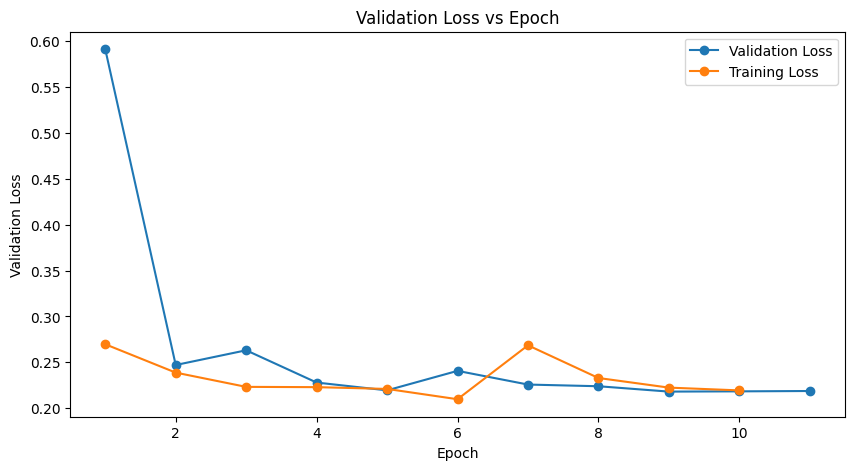

In [61]:
#Plot the training and validation loss

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(hist_cb.val_losses)+1), hist_cb.val_losses, marker="o")
plt.plot(range(1, len(hist_cb.train_losses)+1), hist_cb.train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch")
plt.legend(["Validation Loss", "Training Loss"])
plt.show()

In [62]:
y_true = test_df["Imbalance"]

# returns a list of 1‑D tensors, one per batch
pred_batches = trainer.predict(
    best_model,
    dataloaders=datamodule.test_dataloader()
)


pred = torch.cat(pred_batches).squeeze().detach().numpy()

pred = pred * datamodule.train.scale[0] + datamodule.train.median[0]

metrics = forecast_metrics(y_true, pred, seasonality=1)
df_metrics = pd.DataFrame([metrics], columns=["MAE", "RMSE", "MASE", "RMSSE"])
df_metrics["Features"] = [columns]

display(df_metrics)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,MAE,RMSE,MASE,RMSSE,Features
0,214.728428,281.584505,0.836821,0.852304,"[Imbalance, Imbalance_lag_1, Imbalance_lag_48,..."


# Test to add exogenous features
Train the model multiple time adding each time a single extra feature. 
Use cross validation to assess average performance of added features

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm

def cross_validate_features(data, feature_sets, base_cols, n_splits=5, seed=42):
    """
    Cross-validates each feature set using time series splits.
    
    Args:
        data: DataFrame containing the data
        feature_sets: List of feature tuples to evaluate
        base_cols: Base columns to include in all models
        n_splits: Number of time series folds
        seed: Random seed for reproducibility
        
    Returns:
        DataFrame with cross-validated metrics for each feature set
    """
    # Setup time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store all results
    all_results = []
    
    # For each feature set (including baseline)
    for subset in tqdm(feature_sets, desc="Feature sets"):
        extra_cols = list(subset)
        cols = base_cols + extra_cols
        
        # Create a descriptive run name
        if extra_cols:
            clean_names = ["".join(c.split()) for c in extra_cols]
            run_label = "feat_" + "_".join(clean_names)
        else:
            run_label = "baseline"
            
        # Collect metrics across folds
        fold_metrics = {'mae': [], 'rmse': [], 'mase': [], 'rmsse': []}
        
        # Run cross-validation
        for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
            pl.seed_everything(seed + fold, workers=True)
            
            # Get train and validation sets for this fold
            train_data = data.iloc[train_idx].copy()
            val_data = data.iloc[val_idx].copy()
            
            # Set proper indices for TimeSeriesDataModule
            train_data.set_index('start_date', inplace=True)
            val_data.set_index('start_date', inplace=True)
            combined_data = pd.concat([train_data[cols], val_data[cols]])
            
            # Setup data module
            dm = TimeSeriesDataModule(
                data=combined_data,
                n_val=len(val_data),
                n_test=0,  # Not using test set in CV
                window=48,
                horizon=1,
                normalize="robust",
                batch_size=32,
                num_workers=4
            )
            dm.setup()
            
            # Create and train model
            model = LSTMForecast(
                input_size=len(cols),
                hidden_size=128,
                num_layers=2,
                lr=1e-3,
                bidirectional=True,
                dropout=0.2,
            )
            
            # Setup trainer with limited verbosity for CV
            trainer = pl.Trainer(
                accelerator="gpu",
                max_epochs=7,
                enable_progress_bar=False,  # Reduce output during CV
                logger=False  # No logging during CV
            )
            
            # Train and predict
            trainer.fit(model, dm)
            preds = torch.cat(trainer.predict(model, dm.val_dataloader()))
            preds = preds.squeeze().detach().cpu().numpy()
            
            # Denormalize predictions
            preds = preds * dm.train.scale[0] + dm.train.median[0]
            
            # Calculate metrics
            mae, rmse, mase, rmsse = forecast_metrics(
                val_data[target], preds, seasonality=1
            )
            
            # Store this fold's metrics
            fold_metrics['mae'].append(mae)
            fold_metrics['rmse'].append(rmse)
            fold_metrics['mase'].append(mase)
            fold_metrics['rmsse'].append(rmsse)
            
        # Calculate aggregate statistics
        result = {
            'Features': ";".join(extra_cols) if extra_cols else "BASELINE",
            'n_extra': len(extra_cols),
            'MAE': np.mean(fold_metrics['mae']),
            'MAE_std': np.std(fold_metrics['mae']),
            'RMSE': np.mean(fold_metrics['rmse']),
            'RMSE_std': np.std(fold_metrics['rmse']),
            'MASE': np.mean(fold_metrics['mase']),
            'MASE_std': np.std(fold_metrics['mase']),
            'RMSSE': np.mean(fold_metrics['rmsse']),
            'RMSSE_std': np.std(fold_metrics['rmsse']),
        }
        
        all_results.append(result)
        
        # Print progress
        print(f"CV Results for {run_label}: MAE={result['MAE']:.4f}±{result['MAE_std']:.4f}, RMSE={result['RMSE']:.4f}±{result['RMSE_std']:.4f}")
        
    return pd.DataFrame(all_results)

In [ ]:
# Define base and candidate features
base_cols = ['Imbalance', 'Imbalance_lag_1', 'Imbalance_lag_48', '1/2 Hour of the day_cos'] 
candidate_cols = ['ISP (lag1)', 'LOAD DEVIATION (lag1)', 
                 'WIND DEVIATION CURRENT (lag1)', 'upward_volume_balancing (lag1)',
                 'downward_volume_balancing (lag1)']

# Create feature sets (baseline + individual features)
feature_sets = [()] + [(col,) for col in candidate_cols]

# Run cross-validation
results_df = cross_validate_features(
    feature_sets=feature_sets,
    base_cols=base_cols,
    n_splits=5,
    seed=42
)

# Save results
results_df.to_csv("cv_feature_importance.csv", index=False)

# Find the most consistently beneficial features
baseline_mae = results_df[results_df['Features'] == 'BASELINE']['MAE'].values[0]
baseline_mae_std = results_df[results_df['Features'] == 'BASELINE']['MAE_std'].values[0]

# Filter for features that consistently improve over baseline
significant_features = results_df[
    (results_df['MAE'] < baseline_mae) & 
    (results_df['MAE'] + results_df['MAE_std'] < baseline_mae + baseline_mae_std)
].sort_values('MAE')

print("Features that consistently improve performance:")
display(significant_features)

## Hyperparameter tuning using OPTUNA

In [64]:
columns = ['Imbalance', 'Imbalance_lag_48', '1/2 Hour of the day_cos','LOAD DEVIATION (lag1)'] 

train_df, val_df, test_df, pred_df, sample_df = split_data(data, columns)

Train shape: (85848, 4)
Validation shape: (18396, 4)
Test shape: (18396, 4)


In [ ]:
#test optuna
import optuna
# pull from the pytorch_lightning‐specific path:
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import json


def objective(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_sizes = []
    for i in range(n_layers):
        # name each trial‐parameter uniquely!
        hs = trial.suggest_categorical(f"hidden_size_layer_{i}", [32, 64, 128])
        hidden_sizes.append(hs)

    # --- ohyperparamsts tested---
    dropout       = trial.suggest_float("dropout",      0.1, 0.5, step=0.1)
    lr            = trial.suggest_categorical("lr",      [1e-4, 1e-3, 1e-2])
    bidirectional = trial.suggest_categorical("bidirectional", [True])  # forecasting→False
    batch_size    = trial.suggest_categorical("batch_size",   [8, 16, 32, 64, 128])
    window        = trial.suggest_categorical("window",       [48, 96, 144])

    # --- build model with a list of hidden_sizes ---
    model = LSTMForecast(
        input_size    = len(columns),
        hidden_sizes  = hidden_sizes,   
        lr            = lr,
        bidirectional = bidirectional,
        dropout       = dropout,
    )

    
    dm = TimeSeriesDataModule(
        data       = sample_df,
        n_val      = test_df.shape[0],
        n_test     = test_df.shape[0],
        window     = window,
        horizon    = 1,
        normalize  = "robust",
        batch_size = batch_size,
        num_workers= 8,
    )
    dm.setup()

    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    pruning_cb = PyTorchLightningPruningCallback(trial, monitor="val_loss")

    trainer = pl.Trainer(
        max_epochs=30,
        logger=TensorBoardLogger("tb_logs", name="optuna"),
        callbacks=[early_stop, pruning_cb],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
    )

    trainer.fit(model, dm)
    return trainer.callback_metrics["val_loss"].item()


In [32]:
# 2) Create and run the study
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=100, timeout=3*3600)

# 3) Inspect the best hyperparameters
print("Best val_loss:", study.best_value)
print("Best hyperparameters:", study.best_params)



with open("best_study_optuna.txt", "w", encoding="utf-8") as f:
    json.dump(study.best_params, f, ensure_ascii=False, indent=2)

[I 2025-05-06 07:27:48,791] A new study created in memory with name: no-name-c2f29f0b-219d-4ac3-a5c5-ea7a714b18c6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-05-06 07:27:50.495347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-06 07:27:50.495449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 7.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:29:34,665] Trial 0 finished with value: 0.2901671230792999 and parameters: {'n_layers': 1, 'hidden_size_layer_0': 32, 'dropout': 0.5, 'lr': 0.01, 'bidirectional': True, 'batch_size': 32, 'window': 144}. Best is trial 0 with value: 0.2901671230792999.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 208 K  | train
2 | fc          | Linear            | 257    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
208 K     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:31:48,112] Trial 1 finished with value: 0.2628630995750427 and parameters: {'n_layers': 2, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 128, 'dropout': 0.2, 'lr': 0.001, 'bidirectional': True, 'batch_size': 64, 'window': 144}. Best is trial 1 with value: 0.2628630995750427.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
21

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:34:43,020] Trial 2 finished with value: 0.20958064496517181 and parameters: {'n_layers': 2, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 32, 'dropout': 0.30000000000000004, 'lr': 0.001, 'bidirectional': True, 'batch_size': 64, 'window': 48}. Best is trial 2 with value: 0.20958064496517181.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 137 K  | train
2 | fc          | Linear            | 257    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
--------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:35:46,669] Trial 3 finished with value: 0.23911923170089722 and parameters: {'n_layers': 1, 'hidden_size_layer_0': 128, 'dropout': 0.1, 'lr': 0.001, 'bidirectional': True, 'batch_size': 128, 'window': 96}. Best is trial 2 with value: 0.20958064496517181.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 275 K  | train
2 | fc          | Linear            | 257    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
276 K     Trainable params


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:54:18,668] Trial 4 finished with value: 0.21603769063949585 and parameters: {'n_layers': 3, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 128, 'dropout': 0.4, 'lr': 0.001, 'bidirectional': True, 'batch_size': 16, 'window': 96}. Best is trial 2 with value: 0.20958064496517181.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 76.3 K | train
2 | fc          | Linear            | 129    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
---------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:55:14,480] Trial 5 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 374 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
374 K     Trainable params
0         Non-trainable params
374 K     Total params
1.497     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 07:59:52,357] Trial 6 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 77.3 K | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
77.4 K    Trainable params
0         Non-trainable params
77.4 K    Total params
0.310     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:16:11,176] Trial 7 finished with value: 0.2046850323677063 and parameters: {'n_layers': 2, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 32, 'dropout': 0.1, 'lr': 0.001, 'bidirectional': True, 'batch_size': 8, 'window': 48}. Best is trial 7 with value: 0.2046850323677063.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 35.8 K | train
2 | fc          | Linear            | 129    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
36.0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:17:03,126] Trial 8 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 373 K  | train
2 | fc          | Linear            | 129    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
373 K     Trainable params
0         Non-trainable params
373 K     Total params
1.494     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:18:44,727] Trial 9 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 77.3 K | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
77.4 K    Trainable params
0         Non-trainable params
77.4 K    Total params
0.310     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:40:51,071] Trial 11 finished with value: 0.21035762131214142 and parameters: {'n_layers': 2, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 32, 'dropout': 0.30000000000000004, 'lr': 0.001, 'bidirectional': True, 'batch_size': 8, 'window': 48}. Best is trial 7 with value: 0.2046850323677063.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:57:14,186] Trial 12 pruned. Trial was pruned at epoch 13.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.846     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 08:57:47,796] Trial 13 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 176 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.707     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f72f36a6480><function _MultiProcessingDataLoaderIter.__del__ at 0x7f72f36a6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
         ^ ^ ^  ^^ Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f72f36a6480>^^^^
^Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:00:06,863] Trial 14 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 137 K  | train
2 | fc          | Linear            | 257    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 7.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:08:38,549] Trial 15 pruned. Trial was pruned at epoch 7.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 77.3 K | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
77.4 K    Trainable params
0         Non-trainable params
77.4 K    Total params
0.310     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:33:24,235] Trial 21 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.846     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:40:27,598] Trial 22 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.846     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:47:28,584] Trial 23 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 211 K  | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.846     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f72f36a6480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f72f36a6480>

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
     self._shutdown_workers() 


Training: |          | 0/? [00:00<?, ?it/s]

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      if w.is_alive():  
^ ^  ^ ^ ^ ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
^^  
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^  ^^ ^^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^AssertionError
: AssertionError: can only test a child processcan only test a child process



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:56:20,481] Trial 24 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 77.3 K | train
2 | fc          | Linear            | 65     | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
77.4 K    Trainable params
0         Non-trainable params
77.4 K    Total params
0.310     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 09:57:17,724] Trial 25 pruned. Trial was pruned at epoch 5.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 137 K  | train
2 | fc          | Linear            | 257    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 10:05:26,859] Trial 26 pruned. Trial was pruned at epoch 6.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 278 K  | train
2 | fc          | Linear            | 129    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
----------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.113     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 10:27:05,939] Trial 27 finished with value: 0.2082321047782898 and parameters: {'n_layers': 3, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 64, 'dropout': 0.2, 'lr': 0.001, 'bidirectional': True, 'batch_size': 8, 'window': 48}. Best is trial 7 with value: 0.2046850323677063.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | dropout     | Dropout           | 0      | train
1 | lstm_layers | ModuleList        | 373 K  | train
2 | fc          | Linear            | 129    | train
3 | loss        | MSELoss           | 0      | train
4 | train_mae   | MeanAbsoluteError | 0      | train
5 | val_mae     | MeanAbsoluteError | 0      | train
6 | test_mae    | MeanAbsoluteError | 0      | train
-----------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-05-06 10:28:10,197] Trial 28 pruned. Trial was pruned at epoch 5.


Best val_loss: 0.2046850323677063
Best hyperparameters: {'n_layers': 2, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 32, 'dropout': 0.1, 'lr': 0.001, 'bidirectional': True, 'batch_size': 8, 'window': 48}


In [47]:
study.best_trial


FrozenTrial(number=3, state=1, values=[0.1961708515882492], datetime_start=datetime.datetime(2025, 5, 2, 13, 3, 7, 947257), datetime_complete=datetime.datetime(2025, 5, 2, 13, 5, 27, 776694), params={'hidden_size': 64, 'num_layers': 3, 'dropout': 0.4, 'lr': 0.0019471392268248689, 'bidirectional': True, 'batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.2609007656574249, 1: 0.25389552116394043, 2: 0.24319495260715485, 3: 0.21967683732509613, 4: 0.2170509397983551, 5: 0.2162502259016037, 6: 0.20787270367145538, 7: 0.20754410326480865, 8: 0.32271477580070496, 9: 0.21225391328334808, 10: 0.211912140250206, 11: 0.20428712666034698, 12: 0.20510974526405334, 13: 0.20496347546577454, 14: 0.20689868927001953, 15: 0.20526687800884247, 16: 0.19624556601047516, 17: 0.20954731106758118, 18: 0.19570818543434143, 19: 0.1924062967300415, 20: 0.19519704580307007, 21: 0.19465871155261993, 22: 0.20010311901569366, 23: 0.1947544664144516, 24: 0.1961708515882492}, distributions={

## Train model using Best hyperparameters

- **n_layers**: 2  
- **hidden_size_layer_0**: 64  
- **hidden_size_layer_1**: 32  
- **dropout**: 0.1  
- **lr**: 0.001  
- **bidirectional**: true  
- **batch_size**: 8  
- **window**: 48  


In [ ]:
# Config the datamodule and model with the best hyperparameters

datamodule = TimeSeriesDataModule(data = sample_df,
        n_val = test_df.shape[0],
        n_test = test_df.shape[0],
        window = 48, # giving enough memory to capture daily seasonality
        horizon = 1, # single step
        normalize = "robust", # normalizing the data
        batch_size = 8,
        num_workers = 8,
        )
datamodule.setup()

model = LSTMForecast(
    input_size=len(columns),
    hidden_size=[64, 32],  
    lr=0.001,
    bidirectional=True,
    dropout=0.1,
)


In [ ]:
# ---------------------------------------------------------------------------
# Trainer Configuration
# ---------------------------------------------------------------------------
trainer = pl.Trainer(
    accelerator="gpu",  # Use GPU for training if available
    min_epochs=5,       # Minimum number of epochs to train
    max_epochs=10,      # Maximum number of epochs to train
    callbacks=[
        earlystop_cb,   # Early stopping callback
        checkpoint_cb,  # Checkpoint callback
        progress_bar,   # Progress bar callback
        hist_cb         # Loss history callback
    ],
)

# ---------------------------------------------------------------------------
# Train the Model
# ---------------------------------------------------------------------------
# Fit the model using the trainer and the datamodule
trainer.fit(model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | lstm      | LSTM              | 34.8 K | train
1 | dropout   | Dropout           | 0      | train
2 | fc        | Linear            | 65     | train
3 | loss      | MSELoss           | 0      | train
4 | train_mae | MeanAbsoluteError | 0      | train
5 | val_mae   | MeanAbsoluteError | 0      | train
6 | test_mae  | MeanAbsoluteError | 0      | train
--------------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.140     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.256
Epoch 0, global step 10725: 'val_loss' reached 0.25558 (best 0.25558), saving model to '/notebooks/lightning_logs/version_203/checkpoints/epoch=0-step=10725.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.242
Epoch 1, global step 21450: 'val_loss' reached 0.24245 (best 0.24245), saving model to '/notebooks/lightning_logs/version_203/checkpoints/epoch=1-step=21450.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.222
Epoch 2, global step 32175: 'val_loss' reached 0.22247 (best 0.22247), saving model to '/notebooks/lightning_logs/version_203/checkpoints/epoch=2-step=32175.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 42900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 53625: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 64350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 75075: 'val_loss' was not in top 1


Epoch 00007: reducing learning rate of group 0 to 7.5000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.222. Signaling Trainer to stop.
Epoch 7, global step 85800: 'val_loss' was not in top 1


In [ ]:
# Load the best model from the checkpoint
best_model = LSTMForecast.load_from_checkpoint(checkpoint_cb.best_model_path)

# Extract the true values for the target variable
y_true = test_df["Imbalance"]

# Generate predictions using the test dataloader
pred_batches = trainer.predict(
    best_model,
    dataloaders=datamodule.test_dataloader()
)

# Concatenate predictions from all batches and convert to numpy array
pred = torch.cat(pred_batches).squeeze().detach().numpy()

# Denormalize the predictions
pred = pred * datamodule.train.scale[0] + datamodule.train.median[0]

# Compute forecast metrics
metrics = forecast_metrics(y_true, pred, seasonality=1)

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame([metrics], columns=["MAE", "RMSE", "MASE", "RMSSE"])
df_metrics["Features"] = [columns]

# Display the metrics
display(df_metrics)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

,MAE,RMSE,MASE,RMSSE,Features
0,216.129055,284.285901,0.842279,0.86048,"[Imbalance, Imbalance_lag_1, Imbalance_lag_48,..."


### Save the predictions to CSV

In [44]:
pred = pd.DataFrame(pred, index=test_df.index)
pred.columns = ["LSTM"]
pred

,LSTM
start_date,
2023-12-12 17:00:00+00:00,76.453156
2023-12-12 17:30:00+00:00,224.551056
2023-12-12 18:00:00+00:00,386.728882
2023-12-12 18:30:00+00:00,-65.877350
2023-12-12 19:00:00+00:00,125.131851
...,...
2024-12-29 20:30:00+00:00,-372.915222
2024-12-29 21:00:00+00:00,147.484741
2024-12-29 21:30:00+00:00,-450.979095


In [37]:
pred.to_csv(directory +"/data/lstm.csv", index=True)